      dI_dt  Vout_droop  ripple_RMS  efficiency     dEff_dT   time_s  \
0  0.071755    0.006529    0.007934    0.879740  -35.135169  0.00095   
1  0.067447    0.009223    0.011277    0.880176  294.476290  0.00195   
2  0.092387    0.009055    0.011759    0.880439 -141.464101  0.00295   
3  0.118397    0.008298    0.010067    0.880255 -313.366904  0.00395   
4  0.130625    0.006455    0.008003    0.879724   -6.860491  0.00495   

   fault_label  
0            0  
1            0  
2            0  
3            0  
4            0  
             dI_dt   Vout_droop   ripple_RMS   efficiency       dEff_dT  \
count  9998.000000  9998.000000  9998.000000  9998.000000   9998.000000   
mean      0.110235     0.011944     0.010005     0.876271     -0.710127   
std       0.030238     0.039888     0.004789     0.041678    523.473982   
min       0.046547     0.003680     0.004585     0.281829 -24176.513749   
25%       0.093263     0.007062     0.008551     0.879574   -183.560952   
50%       0.107

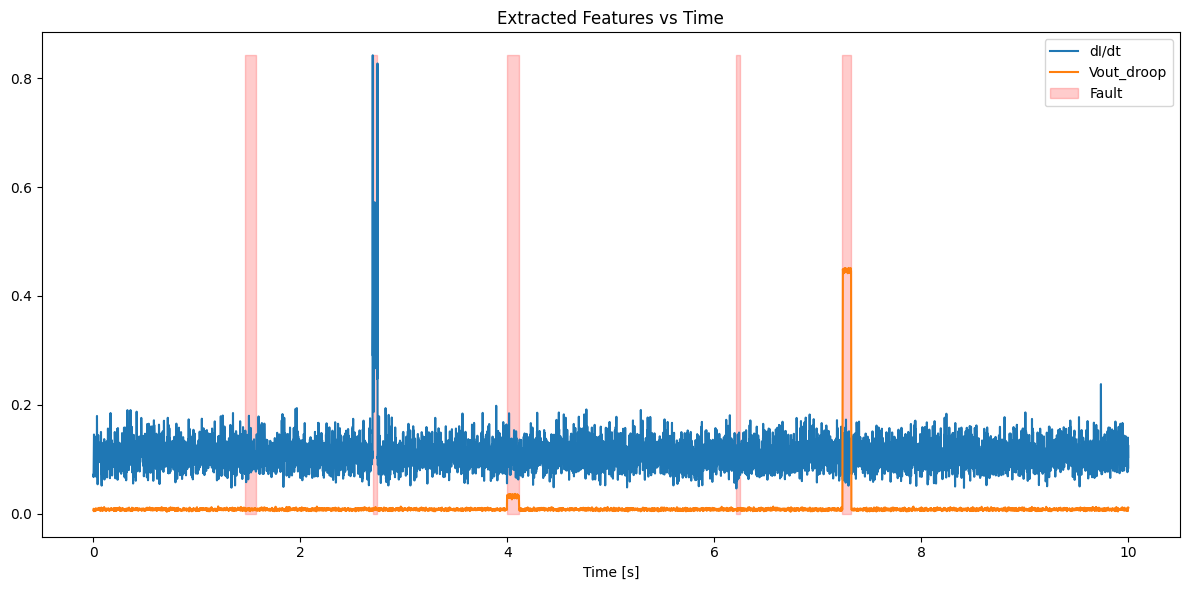

In [1]:
import numpy as np
import pandas as pd

# Reuse or load your data
df = pd.read_csv("../data/cubesat_regulator_raw.csv")
# -----------------------------
# Parameters
# -----------------------------
fs = 10_000             # sampling rate [Hz]
window_ms = 2           # 2 ms sliding window
win_size = int(fs * window_ms / 1000)   # = 20 samples
step_size = win_size // 2               # 50 % overlap

features = []
times = []
labels = []

# -----------------------------
# Sliding-window feature extraction
# -----------------------------
for start in range(0, len(df) - win_size, step_size):
    end = start + win_size
    segment = df.iloc[start:end]

    Vin  = segment["Vin_V"].values
    Iin  = segment["Iin_A"].values
    Vout = segment["Vout_V"].values
    Iout = segment["Iout_A"].values
    Temp = segment["Temp_C"].values

    # dI/dt  – rate of change of input current (A/ms)
    dIdt = np.abs(np.diff(Iin)).mean() * fs / 1000

    # Vout_droop – deviation from nominal 3.3 V baseline
    Vout_droop = np.mean(np.abs(Vout - 3.3))

    # ripple_RMS – AC ripple magnitude (remove DC)
    ripple_RMS = np.sqrt(np.mean((Vout - np.mean(Vout))**2))

    # efficiency – (Vout×Iout)/(Vin×Iin)
    eff = np.mean((Vout * Iout) / (Vin * Iin + 1e-9))

    # dEff/dT – variation of efficiency w.r.t temperature
    dEff_dT = np.gradient((Vout * Iout) / (Vin * Iin + 1e-9),
                          Temp, edge_order=1).mean()

    features.append([dIdt, Vout_droop, ripple_RMS, eff, dEff_dT])
    times.append(segment["time_s"].mean())
    labels.append(segment["fault_label"].max())   # 1 if any sample in window faulty

# -----------------------------
# Assemble feature dataframe
# -----------------------------
df_feat = pd.DataFrame(features, columns=[
    "dI_dt", "Vout_droop", "ripple_RMS", "efficiency", "dEff_dT"
])
df_feat["time_s"] = times
df_feat["fault_label"] = labels

print(df_feat.head())
print(df_feat.describe())

# -----------------------------
# Quick visualization
# -----------------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df_feat["time_s"], df_feat["dI_dt"], label="dI/dt")
plt.plot(df_feat["time_s"], df_feat["Vout_droop"], label="Vout_droop")
plt.fill_between(df_feat["time_s"], 0, df_feat["dI_dt"].max(),
                 where=df_feat["fault_label"]==1, color="r", alpha=0.2, label="Fault")
plt.legend(); plt.title("Extracted Features vs Time"); plt.xlabel("Time [s]")
plt.tight_layout(); plt.show()

# Save for the next stage
df_feat.to_csv("cubesat_features.csv", index=False)
